In [1]:
%matplotlib inline

1. В цветовом пространстве greyscale требуется реализовать алгоритм скалярного равномерного квантования с переменной скоростью для постепенного уменьшения уровней яркости изображения. 
Сохранить изображение, в котором количество уровней яркости << 256, при этом визуально приемлемое качество

In [2]:
from skimage.io import imread, imsave, imshow
import numpy as np
from numpy import clip, dstack
from skimage import img_as_float, img_as_ubyte
from matplotlib import pyplot as plt

In [3]:
img = imread("https://avatars.mds.yandex.net/get-pdb/1025599/e0f9ae3d-039b-4d60-b3b0-ed11842643d5/s1200?webp=false")

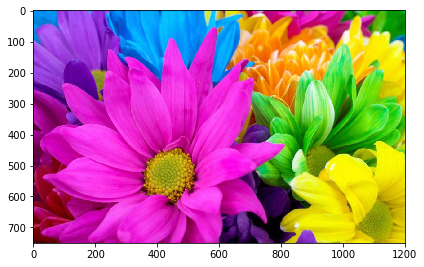

In [4]:
imshow(img);

In [5]:
img_grey = img[:,:,0]
imsave('img_grey.jpg', img_grey)

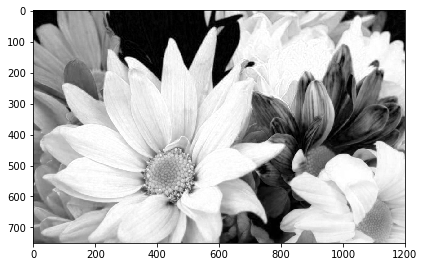

In [6]:
imshow(img_grey);

In [7]:
def change_level(img, L):
    image = np.round(img/L)*L
    image = clip(image,0,255)
    return image.astype('uint8')

Сравнение четырех варинтов уровней яркости

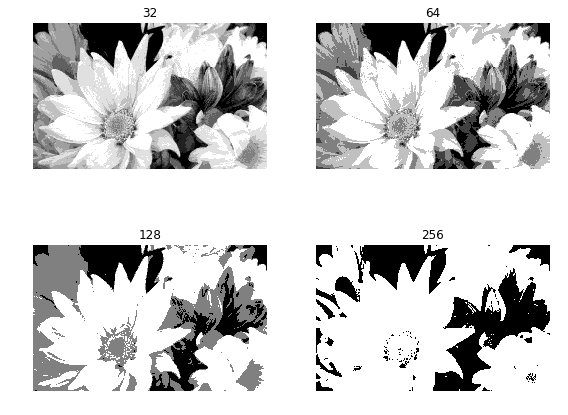

In [8]:
fig=plt.figure(figsize=(8, 8))
columns = 2
rows = 2
n = 5
for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    ax.set_title(2**n)
    plt.axis('off')
    imshow(change_level(img_grey, 2**n))
    n+=1
plt.show()

Наиболее приемлемое для глаза количество уровней яркости: 32 

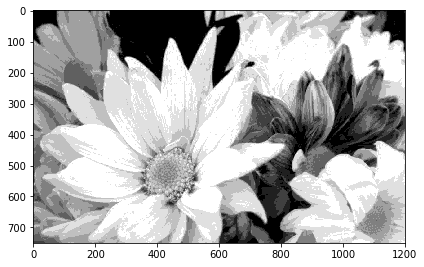

In [9]:
imshow(change_level(img_grey, 32));

Сравнение энтропии

In [13]:
before = entropy(img_grey)
after = entropy(change_level(img_grey, 32))
print("before = ",before, "; after = ",after)

before =  7.510445621391732 ; after =  2.9171122861217063


Среднеквадратичная ошибка

In [14]:
mse(img_grey,change_level(img_grey, 32))

8.522467952418477

2. (Задача децимации) Требуется написать алгоритм прореживания (децимации) цветоразностных каналов. 

In [46]:
def rgb2yuv(img):
    R = img[:,:,0]
    G = img[:,:,1]
    B = img[:,:,2]
    y = R*0.299 + G*0.587 + B*0.114
    Cb = -0.1687*R - 0.3313*G + 0.5*B + 128
    Cr = 0.5*R - 0.4187*G - 0.0813*B + 128
    return np.uint8(dstack((y,Cb,Cr)))

In [47]:
def yuv2rgb(img):
    img = img.astype(np.float)
    Y = img[:,:,0]
    Cb = img[:,:,1]
    Cr = img[:,:,2]
    R = Y + 1.402*(Cr-128)
    G = Y - 0.3414*(Cb-128) - 0.71414*(Cr-128)
    B = Y + 1.772*(Cb-128)
    return np.uint8(np.clip(dstack((R,G,B)),0,255))

In [40]:
def decimation(img, step):
    print("Entropy for origin image: ", entropy(img))
    decimated_u = np.array([np.array([img[i,j,1] for j in range(0,len(img[0]), step)])
                                for i in range(0,len(img),step)])
    decimated_v = np.array([np.array([img[i,j,2] for j in range(0,len(img[0]), step)])
                                for i in range(0,len(img),step)])
    print("Entropy for decimated U channel: ", entropy(decimated_u))
    print("Entropy for decimated V channel: ", entropy(decimated_v))
    
    return (img[:,:,0],decimated_u,decimated_v, step)         

In [42]:
def recover(decimated_img):
    Y = decimated_img[0]
    step = decimated_img[3]
    u = np.array(np.repeat([np.repeat([px for px in row],step) for row in decimated_img[1]],step, axis=0))
    v = np.array(np.repeat([np.repeat([px for px in row],step) for row in decimated_img[2]],step, axis=0))
    
    return np.uint8(dstack((Y,u,v))) 

In [50]:
decimated_img = decimation(rgb2yuv(img),2)
recovered_img = recover(decimated_img)
decoded_img = yuv2rgb(recovered_img)
print("MSE: ",mse(img,decoded_img))

Entropy for origin image:  18.006758159114575
Entropy for decimated U channel:  7.039397098360036
Entropy for decimated V channel:  6.897414252417398
MSE:  4.804805233652383


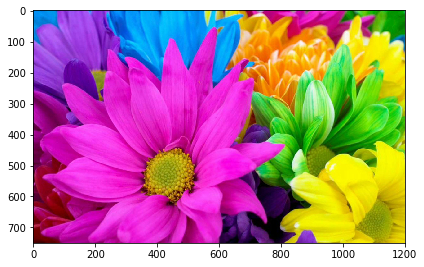

In [464]:
imshow(decoded_img);

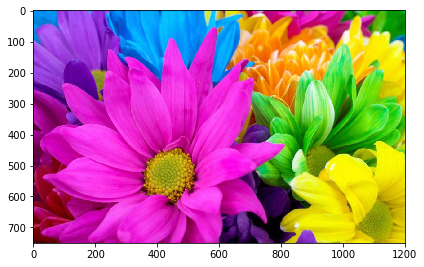

In [337]:
imshow(img);

3. Энтропия и среднеквадратичная ошибка

In [11]:
def entropy(img):
    new_arr = np.array([0 for i in range(256)])
    for row in img:
        for px in row:
            new_arr[px]+=1
    n = img.shape[0]*img.shape[1]
    new_arr = new_arr / n
    return -np.sum([p*np.log2(p) for p in new_arr if p!=0])

In [12]:
def mse(img1, img2):
    dif_sum = np.sum([(px1-px2)**2 for px1,px2 in zip(img1[:,:],img2[:,:])])
    n = img1.shape[0]*img1.shape[1]
    return np.sqrt(dif_sum/n)